
1. **技术指标因子**：
   - MA20：20日移动平均线
   - RSI14：14日相对强弱指数
   - ATR：20日平均真实波幅
   - Momentum20：20日价格动量
   - Turnover_MA5：5日平均换手率

2. **基本面因子**：
   - pe_ttm：滚动市盈率
   - pb：市净率
   - total_mv：总市值（单位：万元）
   - circ_mv：流通市值（单位：万元）


### **因子处理方法及原理总结**

#### **一、技术指标因子处理**

| 因子           | 处理方法                          | 公式/代码                                                                 | 处理原因                                                                 |
|----------------|-----------------------------------|---------------------------------------------------------------------------|--------------------------------------------------------------------------|
| **MA20**       | 价格偏离度标准化                  | `(close - MA20) / MA20`                                                   | 消除价格量纲影响，直观反映股价相对均线位置                               |
| **RSI14**      | 边界截断                          | `RSI14.clip(0, 100)`                                                      | RSI理论范围[0,100]，处理极端计算误差                                     |
| **ATR**        | 价格比率标准化                    | `ATR / close`                                                             | 消除价格规模影响，使波动率可比                                           |
| **Momentum20** | 横截面Z-score标准化               | `(Momentum20 - 组均值)/组标准差`<br>(按交易日分组)                         | 消除市场整体波动影响，突出个股相对动量                                   |
| **Turnover_MA5** | 分位数排名+平方根转换            | ```python<br>df['rank'] = df.groupby('date')['Turnover'].rank(pct=True)<br>df['sqrt'] = np.sqrt(Turnover)<br>``` | 解决严重右偏分布，同时保留线性特征（平方根）和排序信息（排名）           |

#### **二、基本面因子处理**

| 因子         | 处理方法                          | 公式/代码                                                                 | 处理原因                                                                 |
|--------------|-----------------------------------|---------------------------------------------------------------------------|--------------------------------------------------------------------------|
| **pe_ttm**   | 倒数转换+标准化                   | `EP = 1/pe_ttm`<br>`(EP - mean)/std`                                      | 市盈率右偏严重，倒数接近正态分布，标准化后多因子可比                     |
| **pb**       | 行业中性化+标准化                 | ```python<br># 行业调整<br>df['pb_adj'] = df['pb'] - df.groupby('industry')['pb'].transform('mean')<br># 标准化<br>df['pb_std'] = (df['pb_adj'] - df['pb_adj'].mean())/df['pb_adj'].std()<br>``` | 消除行业估值差异，避免行业偏差主导因子。**pb来自同一行业，不需要进行行业中性化处**理                                  |
| **total_mv**<br>**circ_mv** | 对数转换+标准化           | ```python<br>df['log_mv'] = np.log(total_mv)<br>df['mv_z'] = (df['log_mv'] - df['log_mv'].mean())/df['log_mv'].std()<br>``` | 市值呈指数分布，对数转换后近似正态，标准化避免量纲差异                   |

---

### **处理流程的科学依据**

1. **标准化必要性**  
   - *量纲统一*：使不同单位的因子可比（如动量与波动率）  
   - *模型要求*：线性模型需满足正态分布假设（Pearson相关系数、回归分析等）

2. **非线性转换原理**  
   ```math
   \begin{align*}
   \text{对数转换} &: \lim_{x\to\infty}\frac{\ln(x)}{x}=0 \quad \text{（压缩极端值）} \\
   \text{平方根} &: f(x)=\sqrt{x} \quad \text{（弱化右偏，保持单调性）}
   \end{align*}
   ```

3. **行业中性化逻辑**  
   - 通过回归残差法消除行业影响：  
     ```math
     \text{PB}_{\text{中性}} = \text{PB} - (\alpha + \beta \cdot \text{行业虚拟变量})
     ```

4. **排名处理的优势**  
   - 非参数方法，不依赖分布假设  
   - 对异常值鲁棒性强  
   - 保持排序信息不变：  
     ```math
     \text{rank}(x_i) = \frac{\#\{x_j \leq x_i\}}{N} \in [0,1]
     ```


In [1]:
#导入数据
import pandas as pd
daily_df = pd.read_csv('electrical_daily_2024.csv')
basic_df = pd.read_csv('electrical_daily_basic_2024.csv')

daily_df['trade_date'] = pd.to_datetime(daily_df['trade_date'], format='%Y%m%d')
basic_df['trade_date'] = pd.to_datetime(basic_df['trade_date'], format='%Y%m%d')


daily_df = daily_df.sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
basic_df = basic_df.sort_values(['ts_code', 'trade_date']).reset_index(drop=True)

In [2]:
# 比较两个数据框的 trade_date
dates_equal = basic_df['trade_date'].equals(daily_df['trade_date'])

# 检查两个数据框的close列是否完全相同
close_equal = basic_df['close'].equals(daily_df['close'])

print(f"trade_date列是否完全相同: {dates_equal}")
print(f"close列是否完全相同: {close_equal}")

# 显示两个数据框的行数
print(f"\nbasic_df的行数: {len(basic_df)}")
print(f"daily_df的行数: {len(daily_df)}")

# 查看不匹配的数据（如果有的话）
if not dates_equal:
    print("\n日期不匹配的示例:")
    df_comparison = pd.DataFrame({
        'basic_dates': basic_df['trade_date'].head(),
        'daily_dates': daily_df['trade_date'].head()
    })
    print(df_comparison)

trade_date列是否完全相同: True
close列是否完全相同: True

basic_df的行数: 76749
daily_df的行数: 76749


In [3]:
#合并两个数据集
basic_df.drop(columns=['close'], inplace=True)
df = pd.merge(daily_df, basic_df, on=['ts_code', 'trade_date'], how='inner')


In [4]:
# 计算技术指标因子
technical_factors = pd.DataFrame()

# 1. 计算MA20（20日均线）
technical_factors['MA20'] = (
    df.groupby('ts_code', group_keys=False)['close']
    .rolling(window=20, min_periods=10)
    .mean()
    .reset_index(drop=True)
)

# 2. 计算14日RSI
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

technical_factors['RSI14'] = (
    df.groupby('ts_code', group_keys=False)['close']
    .apply(calculate_rsi)
    .reset_index(drop=True)
)

# 3. 计算ATR（平均真实波幅）
def calculate_atr(df_group):
    high = df_group['high']
    low = df_group['low']
    close = df_group['close']
    
    tr1 = high - low
    tr2 = (high - close.shift(1)).abs()
    tr3 = (low - close.shift(1)).abs()
    
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=20, min_periods=10).mean()
    return atr

technical_factors['ATR'] = (
    df.groupby('ts_code', group_keys=False)
    .apply(calculate_atr)
    .reset_index(drop=True)
)

# 4. 计算20日动量
technical_factors['Momentum20'] = (
    df.groupby('ts_code')['close']
    .pct_change(periods=20)
    .reset_index(drop=True)
)

# 5. 计算5日平均换手率
technical_factors['Turnover_MA5'] = (
    df.groupby('ts_code', group_keys=False)['turnover_rate']
    .rolling(window=5)
    .mean()
    .reset_index(drop=True)
)

# 从原始数据中提取基本面因子
fundamental_factors = df[['ts_code', 'trade_date', 'pe_ttm', 'pb', 'total_mv', 'circ_mv']].copy()

# 合并技术指标因子和基本面因子
all_factors = pd.concat([
    fundamental_factors,
    technical_factors
], axis=1)

# 确保没有重复列
all_factors = all_factors.loc[:,~all_factors.columns.duplicated()]

# 按股票代码和交易日期排序
all_factors.sort_values(['ts_code', 'trade_date'], inplace=True)

# 重置索引
all_factors.reset_index(drop=True, inplace=True)


In [5]:
#计算未来1，5，10日收益率
all_factors['close'] = df['close'] 
for n in [1,5,10]:
    all_factors[f'return_{n}d'] = (
         all_factors.groupby('ts_code')['close']
        .pct_change(periods=n)
        .shift(-n)  # 关键：向前移动n天得到未来收益
    )

In [6]:
all_factors

,ts_code,trade_date,pe_ttm,pb,total_mv,circ_mv,MA20,RSI14,ATR,Momentum20,Turnover_MA5,close,return_1d,return_5d,return_10d
0,000009.SZ,2024-01-02,23.9376,3.0625,3.015101e+06,2.982622e+06,NaN,NaN,NaN,NaN,NaN,11.69,0.000855,-0.011976,0.000855
1,000009.SZ,2024-01-03,23.9581,3.0652,3.017680e+06,2.985173e+06,NaN,NaN,NaN,NaN,NaN,11.70,-0.005128,-0.011966,-0.020513
2,000009.SZ,2024-01-04,23.8352,3.0494,3.002205e+06,2.969865e+06,NaN,NaN,NaN,NaN,NaN,11.64,0.012027,0.004296,-0.013746
3,000009.SZ,2024-01-05,24.1219,3.0861,3.038314e+06,3.005585e+06,NaN,NaN,NaN,NaN,NaN,11.78,-0.019525,-0.005942,-0.017827
4,000009.SZ,2024-01-08,23.6510,3.0259,2.978992e+06,2.946902e+06,NaN,NaN,NaN,NaN,0.51162,11.55,0.000000,0.018182,-0.040693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76744,873152.BJ,2024-12-25,209.1686,6.4926,1.675259e+05,9.154620e+04,19.744,26.975477,1.7370,-0.276275,9.21260,16.32,0.002451,NaN,NaN
76745,873152.BJ,2024-12-26,209.6813,6.5085,1.679365e+05,9.177058e+04,19.444,18.951613,1.6570,-0.268336,8.30968,16.36,-0.014059,NaN,NaN
76746,873152.BJ,2024-12-27,206.7334,6.4170,1.655755e+05,9.048040e+04,19.161,19.936373,1.5980,-0.259752,7.95684,16.13,-0.067576,NaN,NaN
76747,873152.BJ,2024-12-30,192.7632,5.9834,1.543866e+05,8.436610e+04,18.820,18.632309,1.5705,-0.311985,6.70224,15.04,-0.005984,NaN,NaN


In [7]:
#统计每一列的缺失值数量
missing_values = all_factors.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("\n缺失值统计:")
print(missing_values)


缺失值统计:
pe_ttm          15940
pb                903
MA20             2871
RSI14            4147
ATR              2871
Momentum20       6380
Turnover_MA5     1276
return_1d         319
return_5d        1595
return_10d       3190
dtype: int64


In [8]:
all_factors.dropna()

,ts_code,trade_date,pe_ttm,pb,total_mv,circ_mv,MA20,RSI14,ATR,Momentum20,Turnover_MA5,close,return_1d,return_5d,return_10d
20,000009.SZ,2024-01-30,23.6305,3.0232,2.976413e+06,2.944351e+06,11.6060,49.615385,0.3600,-0.012831,1.33908,11.54,-0.064125,-0.046794,0.021664
21,000009.SZ,2024-01-31,22.1152,2.8294,2.785551e+06,2.755545e+06,11.5610,36.137072,0.3965,-0.076923,1.50938,10.80,-0.023148,0.119444,0.102778
22,000009.SZ,2024-02-01,21.6032,2.7639,2.721071e+06,2.691759e+06,11.5065,33.139535,0.4125,-0.093643,1.55436,10.55,-0.010427,0.139336,0.127962
23,000009.SZ,2024-02-02,21.3780,2.7351,2.692699e+06,2.663693e+06,11.4395,31.142857,0.4450,-0.113752,1.66776,10.44,-0.042146,0.145594,0.133142
24,000009.SZ,2024-02-05,20.4770,2.6198,2.579214e+06,2.551430e+06,11.3620,28.092784,0.4655,-0.134199,1.35902,10.00,0.100000,0.196000,0.195000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76734,873152.BJ,2024-12-11,254.0271,7.8850,2.034536e+05,1.111793e+05,21.5235,36.738579,3.3060,0.178359,14.14820,19.82,0.028759,-0.147830,-0.176589
76735,873152.BJ,2024-12-12,261.3326,8.1118,2.093047e+05,1.143767e+05,21.6825,40.176879,3.3160,0.184776,15.16800,20.39,-0.043158,-0.161354,-0.197646
76736,873152.BJ,2024-12-13,250.0539,7.7617,2.002714e+05,1.094403e+05,21.7945,21.886792,3.2520,0.129705,13.04452,19.51,-0.055869,-0.123526,-0.173244
76737,873152.BJ,2024-12-16,236.0837,7.3281,1.890825e+05,1.033260e+05,21.9525,29.622063,3.2180,0.207077,12.22196,18.42,-0.040717,-0.014115,-0.183496


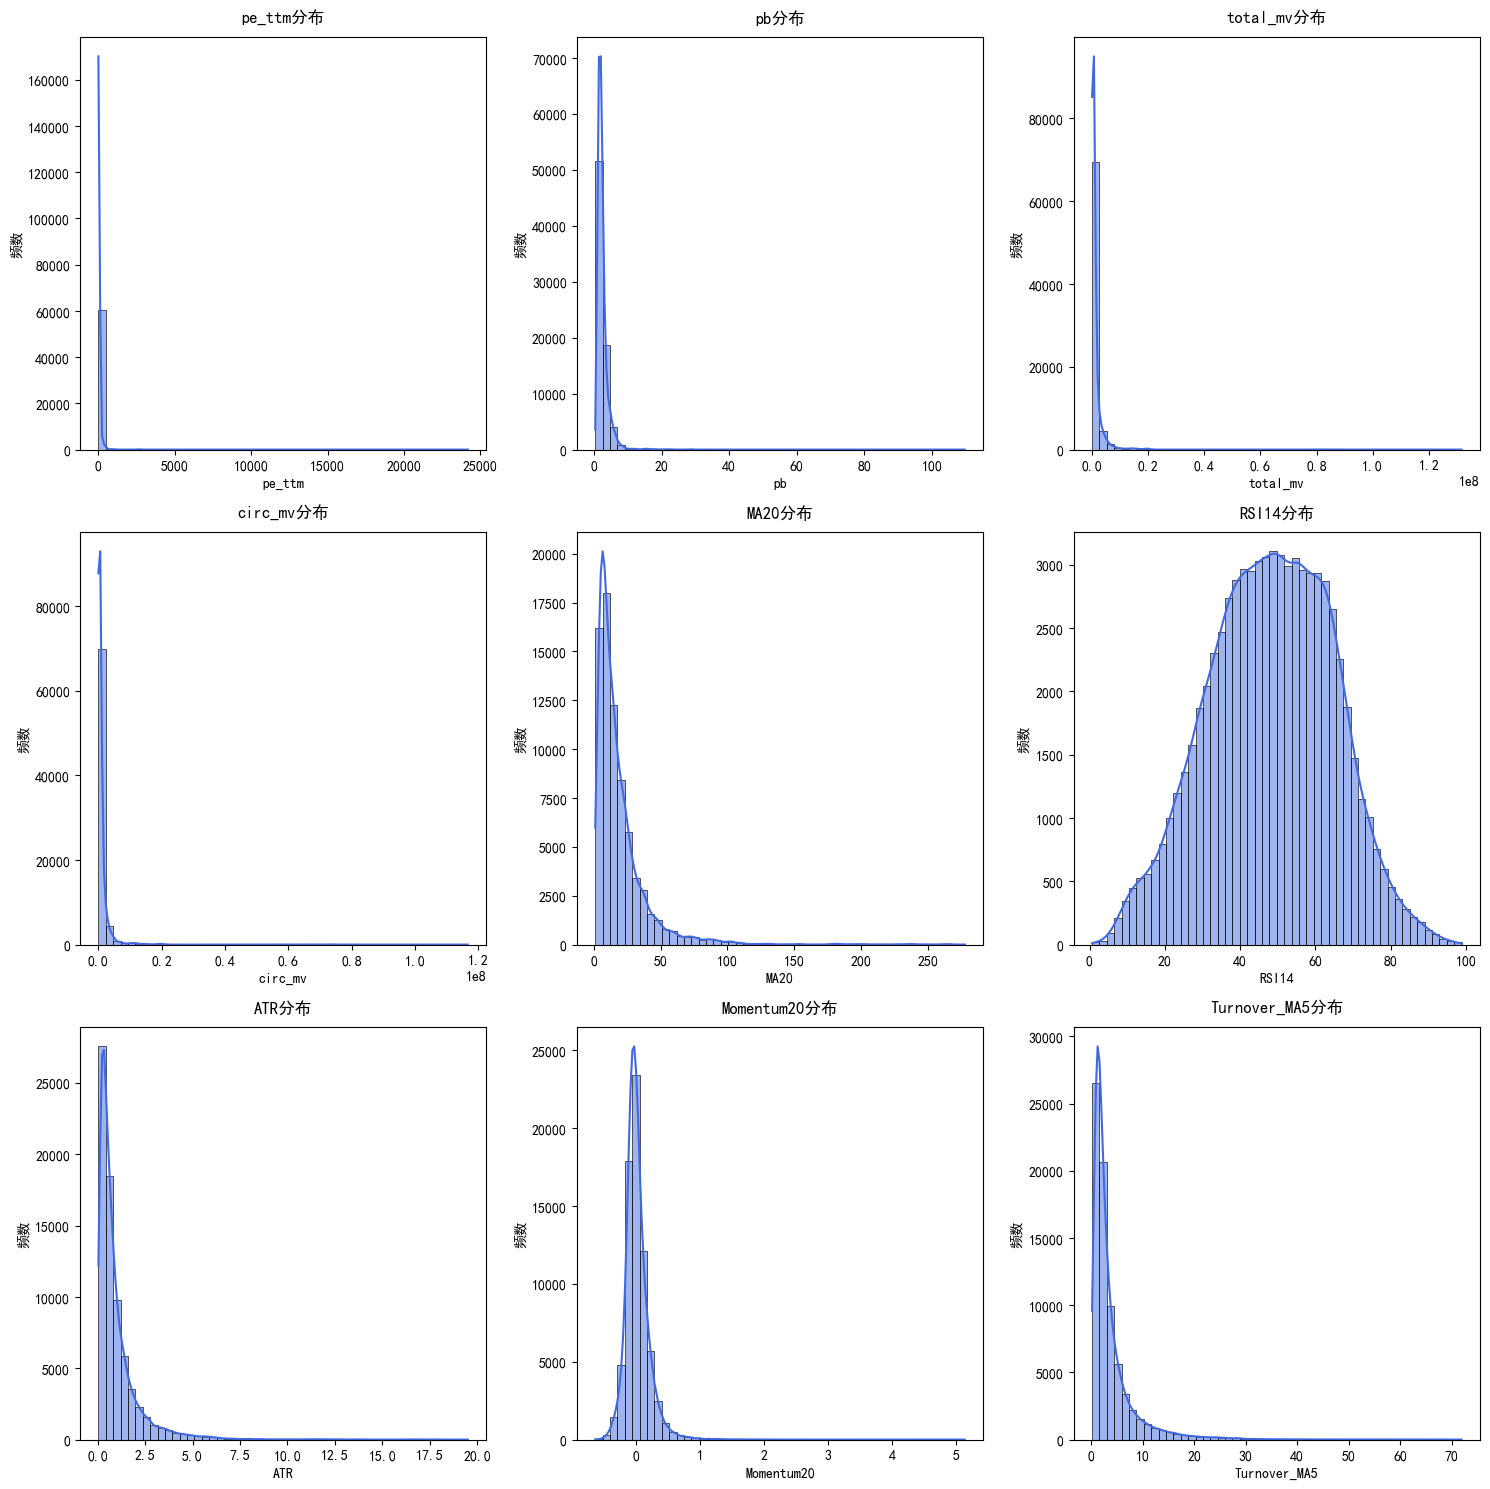


因子基本统计信息:
          pe_ttm         pb      total_mv       circ_mv       MA20      RSI14  \
count  60809.000  75846.000  7.674900e+04  7.674900e+04  73878.000  72602.000   
mean      67.823      2.502  1.383330e+06  1.161335e+06     19.349     48.131   
std      479.004      2.376  5.396072e+06  4.801375e+06     21.869     16.528   
min        4.354      0.341  4.200000e+04  1.739549e+04      1.030      0.673   
25%       19.703      1.496  2.708707e+05  1.896430e+05      7.102     36.471   
50%       29.118      2.031  4.511257e+05  3.571052e+05     13.179     48.534   
75%       48.363      2.804  1.032957e+06  8.666566e+05     23.584     60.344   
max    24179.331    109.681  1.316310e+08  1.166538e+08    277.624     98.829   

             ATR  Momentum20  Turnover_MA5  
count  73878.000   70369.000     75473.000  
mean       0.989       0.018         3.781  
std        1.252       0.193         4.760  
min        0.036      -0.634         0.116  
25%        0.296      -0.090      

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 获取需要绘制的列名
factor_columns = [col for col in all_factors.columns if col not in ['ts_code', 'trade_date','return_1d','return_5d','return_10d','close']]

# 计算需要的行数和列数
n_cols = 3
n_rows = (len(factor_columns) + n_cols - 1) // n_cols

# 创建子图
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()  # 将多维数组转为一维，便于遍历

# 绘制每个因子的分布图
for i, col in enumerate(factor_columns):
    sns.histplot(data=all_factors[col].dropna(), bins=50, kde=True, ax=axes[i], color='royalblue')
    axes[i].set_title(f'{col}分布', pad=10, fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('频数')
    
# 如果子图数量超过因子数量，删除多余的子图
for i in range(len(factor_columns), len(axes)):
    fig.delaxes(axes[i])

# 调整布局
plt.tight_layout()
plt.show()

# 打印基本统计信息
print("\n因子基本统计信息:")
print(all_factors[factor_columns].describe().round(3))

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer, StandardScaler

def preprocess_factors(df):
    """完整的因子预处理流水线"""
    # 1. 基础异常值处理 (保留原始列)
    def winsorize_series(series, lower=0.01, upper=0.99):
        return series.clip(series.quantile(lower), series.quantile(upper))
    
    raw_cols = ['MA20', 'pb', 'total_mv', 'circ_mv', 'pe_ttm', 
               'ATR', 'Momentum20', 'Turnover_MA5', 'close']
    for col in raw_cols:
        df[f'raw_{col}'] = df[col]  # 保留原始数据
        if col in df.columns:
            df[col] = winsorize_series(df[col])

    # 2. 专业因子转换
    # 2.1 均线偏离度 (带边界保护)
    df['MA20_deviation'] = np.where(
        df['raw_MA20'] > 0, 
        (df['close'] - df['MA20']) / df['MA20'],
        np.nan
    )
    
    # 2.2 波动率标准化 (ATR比率)
    df['ATR_ratio'] = np.where(
        df['close'] > 0,
        df['ATR'] / df['close'],
        np.nan
    )
    
    # 2.3 动量标准化 (基于横截面)
    df['Momentum20_z'] = df.groupby('trade_date')['Momentum20'].transform(
        lambda x: (x - x.mean()) / x.std()
    )
    
    # 2.4 估值指标转换
    df['EP'] = np.where(
        df['pe_ttm'] > 0, 
        1 / df['pe_ttm'], 
        np.nan
    )
    
    # 2.5 规模指标对数转换
    for mv_col in ['total_mv', 'circ_mv']:
        df[f'log_{mv_col}'] = np.where(
            df[mv_col] > 0,
            np.log(df[mv_col]),
            np.nan
        )
    
    # 2.6 换手率变换
    df['sqrt_turnover'] = np.sqrt(df['Turnover_MA5'])
    df['turnover_rank'] = df.groupby('trade_date')['Turnover_MA5'].rank(pct=True)
    
    # 3. 必须标准化的因子处理
    need_standardize = ['EP', 'pb', 'log_total_mv', 'log_circ_mv']
    scaler = StandardScaler()
    df[need_standardize] = scaler.fit_transform(df[need_standardize])
    
    # 4. 特殊因子处理
    df['RSI14'] = df['RSI14'].clip(0, 100)  # RSI边界控制
    
    return df

# 执行预处理
all_factors = preprocess_factors(all_factors)

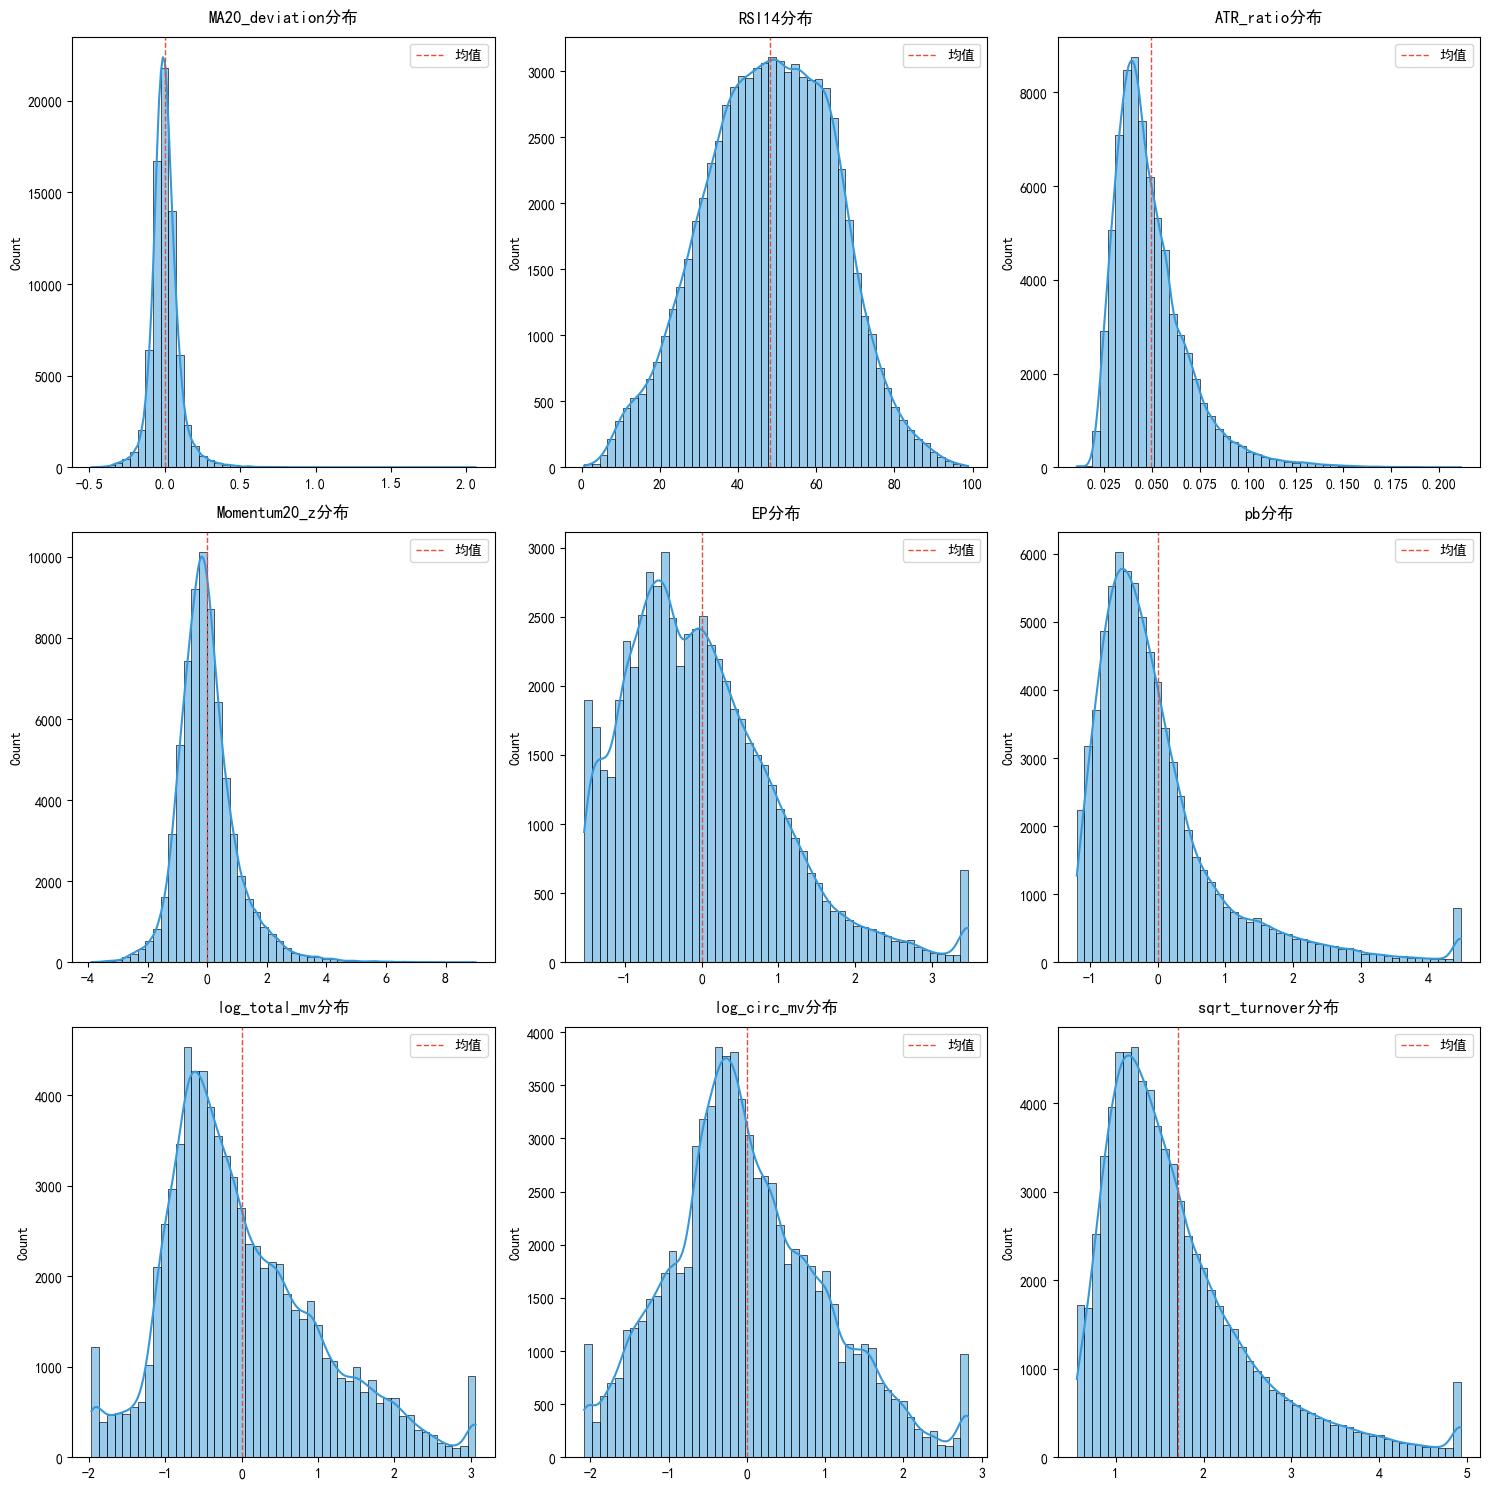


处理后因子统计信息：
       MA20_deviation      RSI14  ATR_ratio  Momentum20_z         EP         pb  log_total_mv  log_circ_mv  sqrt_turnover
count       73878.000  72602.000  73878.000     70369.000  60809.000  75846.000     76749.000    76749.000      75473.000
mean            0.001     48.131      0.049        -0.000     -0.000      0.000        -0.000        0.000          1.715
std             0.096     16.528      0.019         0.998      1.000      1.000         1.000        1.000          0.872
min            -0.487      0.673      0.011        -3.880     -1.532     -1.193        -1.966       -2.081          0.557
25%            -0.049     36.471      0.036        -0.596     -0.730     -0.637        -0.697       -0.639          1.101
50%            -0.005     48.534      0.045        -0.115     -0.142     -0.262        -0.212       -0.112          1.484
75%             0.043     60.344      0.058         0.435      0.564      0.278         0.575        0.627          2.077
max         

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 筛选需要绘制的处理后因子列（根据您的处理步骤）
processed_factors = [
    'MA20_deviation',    # MA20偏离度
    'RSI14',
    'ATR_ratio',         # ATR比率
    'Momentum20_z',      # 标准化动量
    'EP',                # 盈利收益率
    'pb',
    'log_total_mv',      # 对数总市值
    'log_circ_mv',       # 对数流通市值
    'sqrt_turnover',     # 平方根换手率
]

# 计算子图行列数
n_cols = 3
n_rows = (len(processed_factors) + n_cols - 1) // n_cols

# 创建子图
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

# 绘制每个处理后的因子分布
for i, factor in enumerate(processed_factors):
    sns.histplot(
        data=all_factors[factor].dropna(),
        bins=50, 
        kde=True, 
        ax=axes[i],
        color='#3498db'  # 统一颜色
    )
    axes[i].set_title(f'{factor}分布', pad=10, fontsize=12)
    axes[i].set_xlabel('')
    
    # 添加正态分布参考线（适用于连续型因子）
    if factor not in ['turnover_rank']:
        axes[i].axvline(
            x=all_factors[factor].mean(),
            color='#e74c3c',
            linestyle='--',
            linewidth=1,
            label='均值'
        )
        axes[i].legend()

# 删除多余子图
for j in range(len(processed_factors), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 输出统计信息（限制显示列宽）
pd.set_option('display.width', 200)
print("\n处理后因子统计信息：")
print(all_factors[processed_factors].describe().round(3))

In [12]:
selected_columns = [
    'ts_code',          # 股票代码
    'trade_date',       # 交易日期
    'return_1d',        # 1日收益率
    'return_5d',        # 5日收益率  
    'return_10d',       # 10日收益率
    'close',           # 收盘价

    'MA20_deviation',   # MA20偏离度
    'RSI14',            # RSI指标
    'ATR_ratio',        # ATR比率  
    'Momentum20_z',     # 标准化动量
    'EP',               # 盈利收益率（PE倒数）
    'pb',               # 市净率（标准化后）
    'log_total_mv',     # 对数总市值
    'log_circ_mv',      # 对数流通市值
    'sqrt_turnover',    # 平方根换手率
    'turnover_rank'     # 换手率分位数排名
]
processed_data = all_factors[selected_columns]

In [13]:
processed_data.to_csv('factors.csv', index=False)